Import Libraries

In [1]:
"""
Customer Happiness Analysis
This code analyzes customer survey data to predict customer happiness.
"""

# Basic libraries
import pandas as pd
import numpy as np

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

Analysis Functions-EDA

In [2]:
def perform_basic_eda(df):
    """
    Perform basic exploratory data analysis on customer survey data.

    Args:
        df (pd.DataFrame): Customer survey dataframe containing ratings and happiness.

    Returns:
        None: Displays plots and prints basic statistics.
    """
    print("\nData Overview:")
    print("Shape:", df.shape)
    print("\nClass distribution:")
    print(df['Y'].value_counts(normalize=True))

    plt.figure(figsize=(15, 5))

    # Correlation plot
    plt.subplot(1, 3, 1)
    correlation_matrix = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')

    # Target distribution
    plt.subplot(1, 3, 2)
    sns.countplot(data=df, x='Y')
    plt.title('Customer Happiness Distribution')

    # Features by target
    plt.subplot(1, 3, 3)
    df_melted = df.melt(id_vars=['Y'], value_vars=['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
    sns.boxplot(data=df_melted, x='variable', y='value', hue='Y')
    plt.title('Ratings by Customer Happiness')

    plt.tight_layout()
    plt.show()

Visualization Functions

In [3]:
def plot_confusion_matrices(y_test, predictions):
    """
    Create confusion matrices to visualize model predictions.

    Args:
        y_test (array): Actual customer happiness values.
        predictions (dict): Dictionary of model predictions.

    Returns:
        None: Displays confusion matrix plots for each model.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, (name, y_pred) in enumerate(predictions.items()):
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f'{name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def plot_average_predictions(y_test, predictions):
    """
    Compare average predicted vs actual customer happiness.

    Args:
        y_test (array): Actual customer happiness values.
        predictions (dict): Dictionary of model predictions.

    Returns:
        None: Displays bar plot comparing actual vs predicted averages.
    """
    avg_actual = np.mean(y_test)
    model_averages = {name: np.mean(pred) for name, pred in predictions.items()}

    all_averages = {
        'Actual': avg_actual,
        **model_averages
    }

    plt.figure(figsize=(8, 6))
    plt.bar(all_averages.keys(), all_averages.values(),
            color=['red', 'blue', 'green', 'purple'])

    plt.axhline(avg_actual, color='red', linestyle='--', label='Actual Average')
    plt.ylabel('Proportion of Happy Customers')
    plt.title('Actual vs Predicted Customer Happiness')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

 Feature Engineering Functions

In [4]:
def add_interaction_features(df):
    """
    Create interaction features from customer ratings.

    Args:
        df (pd.DataFrame): Original survey dataframe.

    Returns:
        pd.DataFrame: Dataframe with new interaction features added.
    """
    df = df.copy()
    df['service_score'] = df['X1'] * df['X5']  # Delivery × Courier
    df['value_score'] = (df['X2'] * df['X3']) / df['X4']  # Quality/Price
    df['experience_score'] = df['X5'] * df['X6']  # Courier × App
    return df

def add_threshold_features(df):
    """
    Create binary features for high/low satisfaction thresholds.

    Args:
        df (pd.DataFrame): Original survey dataframe.

    Returns:
        pd.DataFrame: Dataframe with new threshold features added.
    """
    df = df.copy()
    df['high_delivery'] = (df['X1'] >= 4).astype(int)
    df['high_value'] = ((df['X2'] >= 4) & (df['X3'] >= 4)).astype(int)
    df['high_service'] = ((df['X5'] >= 4) & (df['X6'] >= 4)).astype(int)
    df['delivery_issues'] = (df['X1'] <= 2).astype(int)
    df['value_issues'] = (df['X4'] >= 4).astype(int)
    return df

def add_aggregate_features(df):
    """
    Create aggregate features from customer ratings.

    Args:
        df (pd.DataFrame): Original survey dataframe.

    Returns:
        pd.DataFrame: Dataframe with new aggregate features added.
    """
    df = df.copy()
    df['avg_rating'] = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].mean(axis=1)
    df['high_ratings_count'] = (df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']] >= 4).sum(axis=1)
    df['low_ratings_count'] = (df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']] <= 2).sum(axis=1)
    return df

 Load and Process Data

Saving ACME-HappinessSurvey2020.csv to ACME-HappinessSurvey2020.csv

Data Overview:
Shape: (126, 7)

Class distribution:
Y
1    0.547619
0    0.452381
Name: proportion, dtype: float64


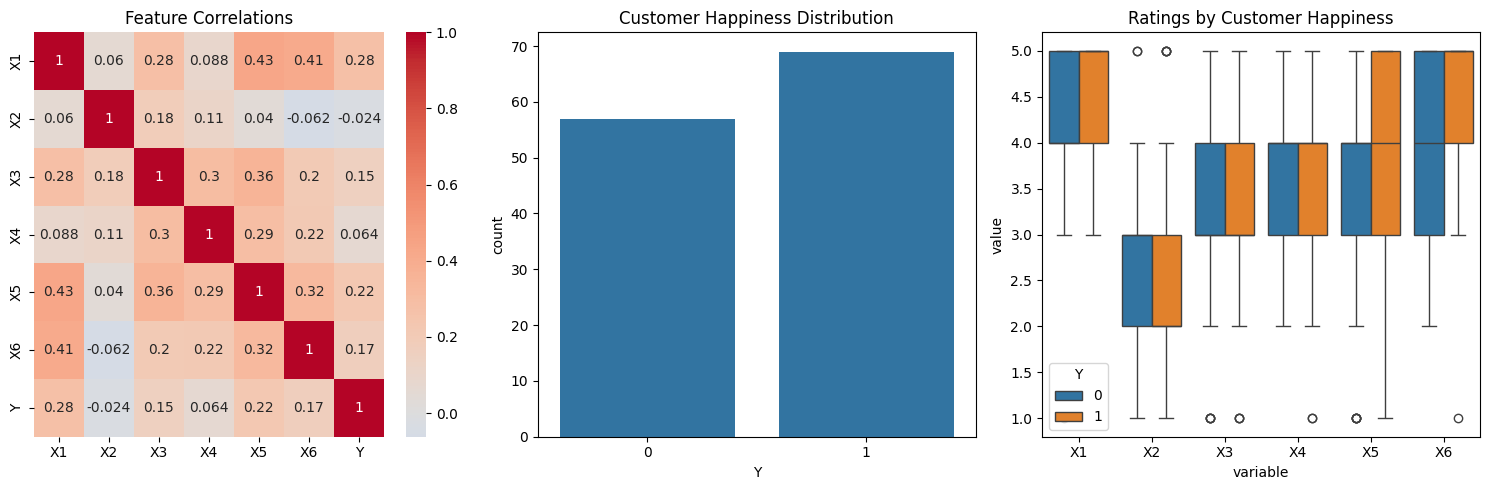

In [5]:
# Load data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Add engineered features
df_engineered = df.copy()
df_engineered = add_interaction_features(df_engineered)
df_engineered = add_threshold_features(df_engineered)
df_engineered = add_aggregate_features(df_engineered)

# Run initial EDA
perform_basic_eda(df)

Prepare Data and Train Models

In [6]:
# Define features
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
           'service_score', 'value_score', 'experience_score',
           'high_delivery', 'high_value', 'high_service',
           'delivery_issues', 'value_issues',
           'avg_rating', 'high_ratings_count', 'low_ratings_count']

# Prepare data
X = df_engineered[features]
y = df_engineered['Y']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, min_samples_split=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=200, random_state=42)
}

# Train and evaluate models
predictions = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Decision Tree Results:
Accuracy: 0.538

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.47      0.73      0.57        11

    accuracy                           0.54        26
   macro avg       0.57      0.56      0.54        26
weighted avg       0.58      0.54      0.53        26


Random Forest Results:
Accuracy: 0.538

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.47      0.82      0.60        11

    accuracy                           0.54        26
   macro avg       0.59      0.58      0.53        26
weighted avg       0.61      0.54      0.52        26


XGBoost Results:
Accuracy: 0.654

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.57      0.73      0.64        

Visualize Results

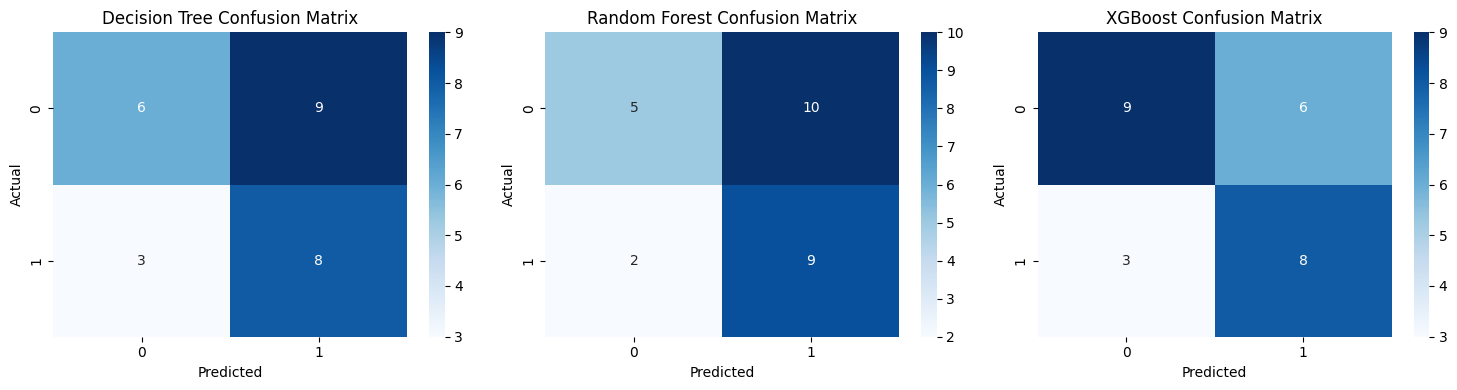

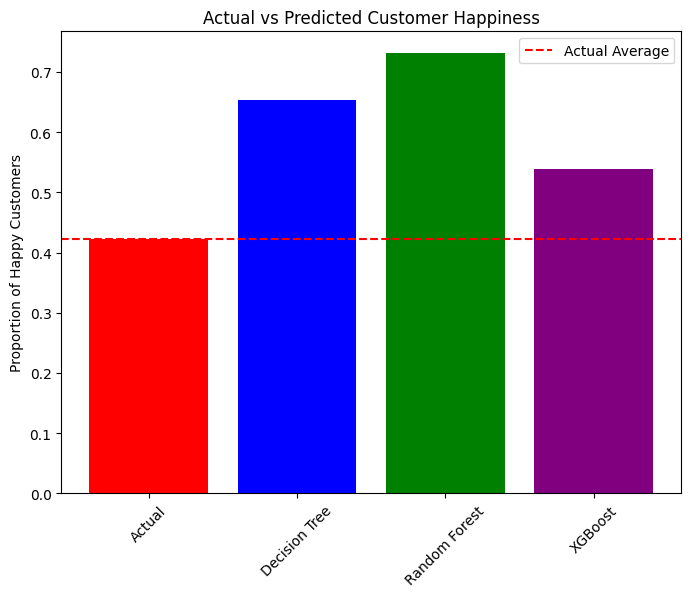

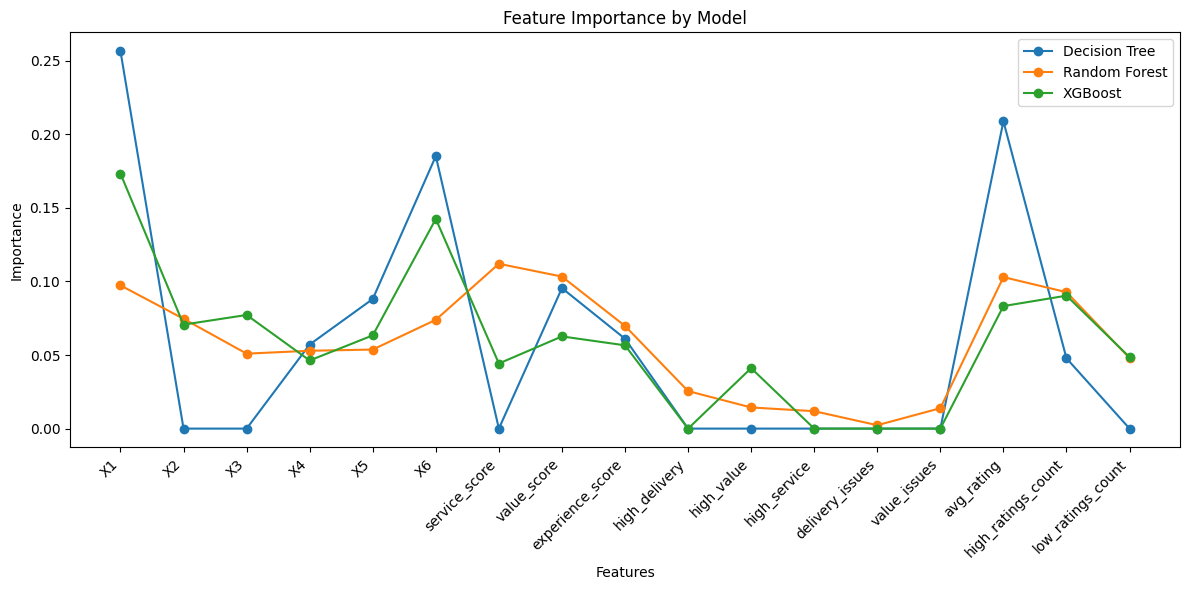

In [7]:
# Plot confusion matrices
plot_confusion_matrices(y_test, predictions)

# Plot average predictions comparison
plot_average_predictions(y_test, predictions)

# Plot feature importance
plt.figure(figsize=(12, 6))
for name, model in models.items():
    plt.plot(features, model.feature_importances_, 'o-', label=name)
plt.title('Feature Importance by Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()